In [11]:
import numpy as np

import cv2 as cv 
import seaborn as sns 
from matplotlib import pyplot as plt 

import os 
import time
import joblib 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV , train_test_split,cross_val_predict
from sklearn.metrics import accuracy_score,precision_score,f1_score,confusion_matrix,recall_score,roc_auc_score,roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Dropout,Flatten,MaxPooling2D,Conv2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:
dataset_folder = '../Dataset/Images'
X = []
y=[]
for folder in os.listdir(dataset_folder):
    path = os.path.join(dataset_folder,folder)
    for image in os.listdir(path):
        image_path = os.path.join(path,image)
        img  = cv.imread(image_path)
        
        #Checks if image is passed correctly
        if img is None: 
            print("Failed to load image: ",image_path)
            continue
        
        X.append(img)

        if folder == 'TSImages':
            y.append('ASD')
        else:
            y.append('Non-ASD')



print("Length of X",len(X))
print("Length of y",len(y))

print("Shape of data",X[0].shape)



Length of X 547
Length of y 547
Shape of data (480, 640, 3)


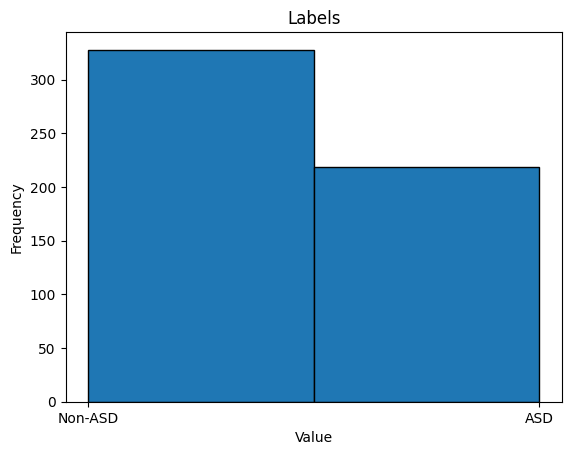

In [20]:
plt.hist(y,bins=2,edgecolor='black')
plt.title("Labels")
plt.xlabel('Value')
plt.ylabel("Frequency")
plt.show()

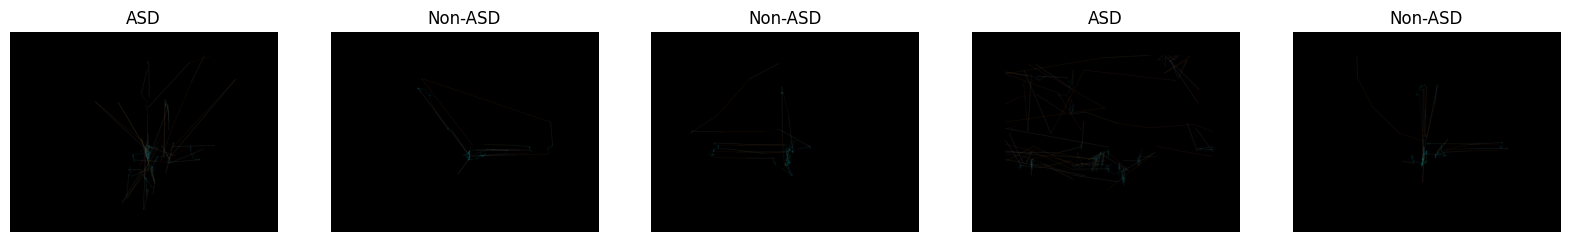

In [21]:
random_indices = np.random.choice(len(X), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i, idx in enumerate(random_indices):
    axes[i].imshow(cv.cvtColor(X[idx],cv.COLOR_BGR2RGB))  
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(y[idx])

plt.show()


## Preproccess

#### Normalize

In [4]:
for i,image in enumerate(X): 
    if image is not None:
        X[i]= image / 255.0
    else: 
        print(f"Skipping invalid image at index: {i}")
if len(X) > 0:
    print("Shape of first normalized image:", X[0].shape)

print("Number of images:", len(X))

Shape of first normalized image: (480, 640, 3)
Number of images: 547


#### Grayscale

In [5]:
for i,img in enumerate(X):
    if img is not None:
        
        if img.dtype == np.float64:
            img_32f = img.astype(np.float32)  
            grayscale_image = cv.cvtColor(img_32f, cv.COLOR_BGR2GRAY)
        
        elif img.dtype == np.uint16:
            img_32f = img.astype(np.float32)  
            grayscale_image = cv.cvtColor(img_32f, cv.COLOR_BGR2GRAY)
        
        elif img.dtype == np.float32 or img.dtype == np.uint8:
            grayscale_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        else:
            print(f"Unsupported image depth at index {i}: {img.dtype}")
            continue
    
        X[i] = grayscale_image
    
    else:
        print(f"Skipping invalid image at index: {i}")

if len(X) > 0:
    print("Shape of first grayscale image:", X[0].shape)

print("Number of images:", len(X))

Shape of first grayscale image: (480, 640)
Number of images: 547


#### Resize

In [7]:
for i,image in enumerate(X):
    if image is not None:
       resized_image =cv.resize(image,(225,225))
       X[i] = resized_image
    else:
       print(f"Skipping invalid image at index: {i}")

if len(X) > 0:
    print("Shape of first resized image:", X[0].shape)

print("Number of images:", len(X))    

Shape of first resized image: (225, 225)
Number of images: 547


### Split pre-proccesed  dataset into training and testing

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print("Training  set size: ",len(X_train)," shape ", X_train[0].shape)
print("Testing  set size: ",len(X_test)," shape ", X_test[0].shape)

# Flatten the datasets 
X_train_flatten =[]
X_test_flatten =[]

for img in  X_train: 
    X_train_flatten.append(img.flatten())
    
for img in  X_test: 
    X_test_flatten.append(img.flatten())
    
X_train_flatten = np.array(X_train_flatten)
X_test_flatten = np.array(X_test_flatten)

print("Training   Flatten set size: ",len(X_train)," shape ", X_train_flatten[0].shape)
print("Testing Flatten  set size: ",len(X_test)," shape ", X_test_flatten[0].shape)



Training  set size:  437  shape  (225, 225)
Testing  set size:  110  shape  (225, 225)
Training   Flatten set size:  437  shape  (50625,)
Testing Flatten  set size:  110  shape  (50625,)


In [9]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(y_train)
test_labels_encoded = label_encoder.transform(y_test)

# Ensure labels are float32
train_labels_encoded = train_labels_encoded.astype(np.float32)
test_labels_encoded = test_labels_encoded.astype(np.float32)

train_data = np.array(X_train)
test_data = np.array(X_test)


## SVM

In [27]:
svm = SVC(kernel='linear', random_state=42,probability=True)

svm.fit(X_train_flatten, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [28]:
start_time = time.time()
y_pred = svm.predict(X_test_flatten)
end_time = time.time()


prediction_time = end_time - start_time
print("-----Support Vector Machine Metrics---")

print("Prediction time (seconds):", prediction_time)
print("Average time for each prediction (seconds): ",prediction_time/len(y_test))

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,pos_label='Non-ASD')
recall = recall_score(y_test,y_pred,pos_label='Non-ASD')
f1 = f1_score(y_test,y_pred,pos_label='Non-ASD')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall {recall}")
print(f"F1-Score: {f1}")



-----Support Vector Machine Metrics---
Prediction time (seconds): 7.050146102905273
Average time for each prediction (seconds):  0.06409223729913885
Accuracy: 0.6909090909090909
Precision: 0.6986301369863014
Recall 0.8095238095238095
F1-Score: 0.7500000000000001


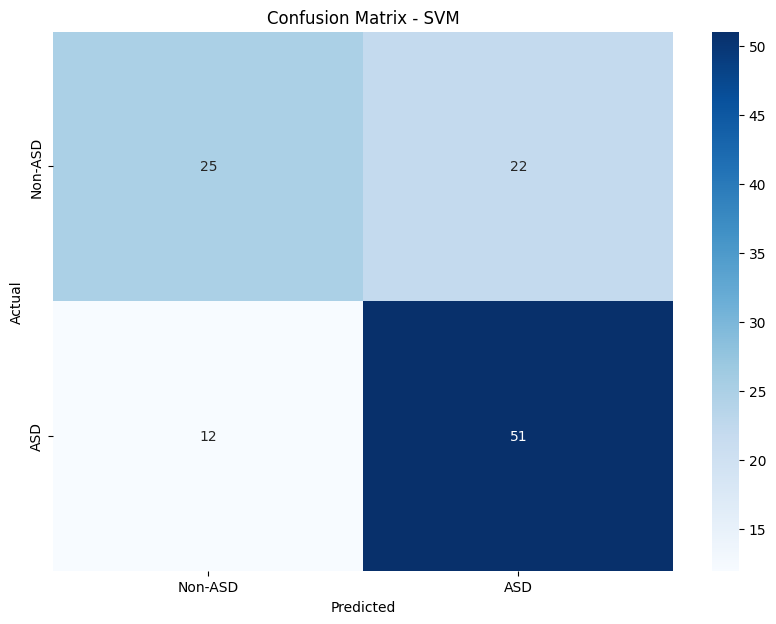

In [29]:
conf_matrix = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-ASD', 'ASD'], yticklabels=['Non-ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

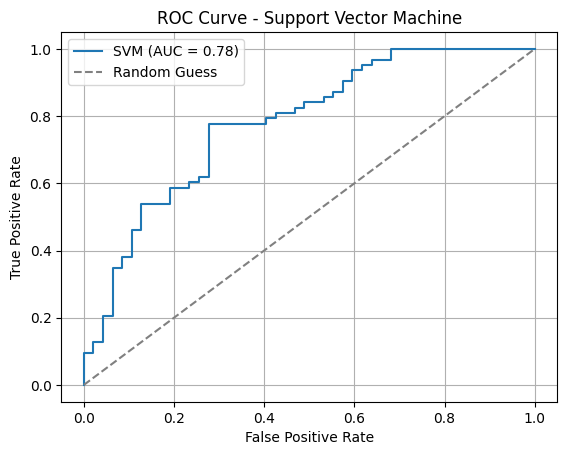

In [30]:
svm_probs = svm.predict_proba(X_test_flatten)[:, 1]
svm_auc =roc_auc_score(y_test, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs,pos_label='Non-ASD')

plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend()
plt.grid(True)


## Random Forest

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_flatten,y_train) 



RandomForestClassifier()

In [14]:
# Save the Random Forest model to a file
joblib_file = "../Model/random_forest_model.pkl"
joblib.dump(rf, joblib_file)


['../Model/random_forest_model.pkl']

### Evaluating the model

In [32]:


start_time = time.time()
y_pred = rf.predict(X_test_flatten)
end_time = time.time()


prediction_time = end_time - start_time

print("-----Random Forest Metrics---")

print("Prediction time (seconds):", prediction_time)
print("Average time for each prediction (seconds): ",prediction_time/len(y_test))

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,pos_label='Non-ASD')
recall = recall_score(y_test,y_pred,pos_label='Non-ASD')
f1 = f1_score(y_test,y_pred,pos_label='Non-ASD')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall {recall}")
print(f"F1-Score: {f1}")

-----Random Forest Metrics---
Prediction time (seconds): 0.02655506134033203
Average time for each prediction (seconds):  0.000241409648548473
Accuracy: 0.7363636363636363
Precision: 0.7361111111111112
Recall 0.8412698412698413
F1-Score: 0.7851851851851852


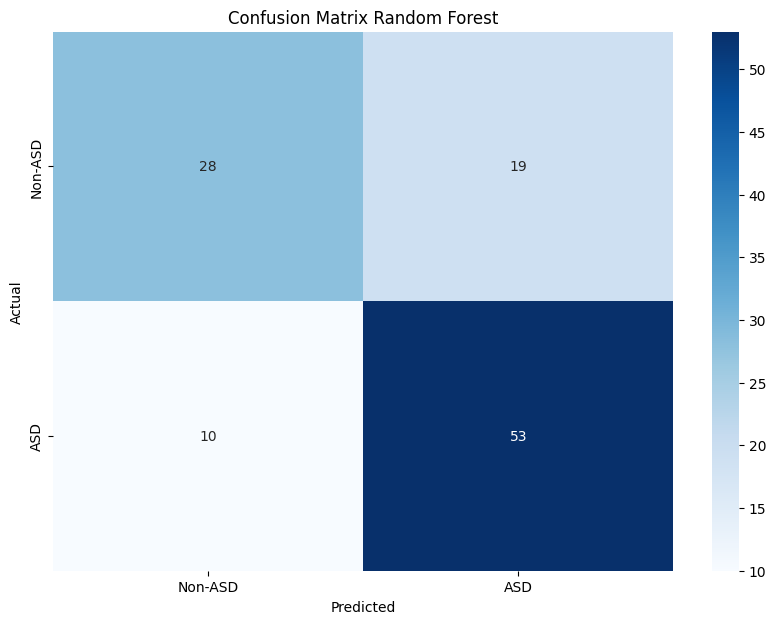

In [33]:
conf_matrix = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-ASD', 'ASD'], yticklabels=['Non-ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Random Forest')
plt.show()

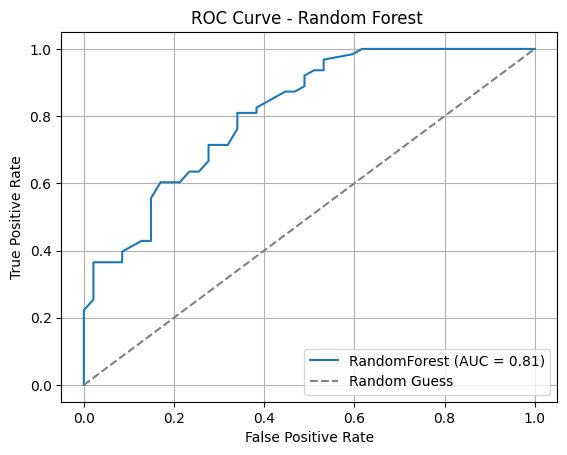

In [34]:
rf_probs = rf.predict_proba(X_test_flatten)[:, 1]
rf_auc =roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs,pos_label='Non-ASD')

plt.plot(rf_fpr, rf_tpr, label=f'RandomForest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest ')
plt.legend()
plt.grid(True)


## Binary Classification with Neural Network

In [35]:
model = Sequential([
    Flatten(input_shape=(225,225)),
    Dense(128,activation='relu'),
    Dense(64, activation='relu'),      
    Dropout(0.5),                      
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam',loss="binary_crossentropy",metrics=['accuracy'])


In [36]:

history = model.fit(train_data,train_labels_encoded,epochs=15,batch_size=32,validation_split=0.2,verbose=1)

Epoch 1/15
11/11 [==============================] - 3s 184ms/step - loss: 0.6668 - accuracy: 0.5903 - val_loss: 0.6017 - val_accuracy: 0.7273
Epoch 2/15
11/11 [==============================] - 1s 137ms/step - loss: 0.5190 - accuracy: 0.8309 - val_loss: 0.5264 - val_accuracy: 0.7727
Epoch 3/15
11/11 [==============================] - 2s 157ms/step - loss: 0.3770 - accuracy: 0.8940 - val_loss: 0.5059 - val_accuracy: 0.7500
Epoch 4/15
11/11 [==============================] - 2s 138ms/step - loss: 0.2502 - accuracy: 0.9542 - val_loss: 0.4946 - val_accuracy: 0.6818
Epoch 5/15
11/11 [==============================] - 2s 148ms/step - loss: 0.1340 - accuracy: 0.9885 - val_loss: 0.4992 - val_accuracy: 0.7386
Epoch 6/15
11/11 [==============================] - 1s 133ms/step - loss: 0.0787 - accuracy: 0.9857 - val_loss: 0.5329 - val_accuracy: 0.7045
Epoch 7/15
11/11 [==============================] - 2s 138ms/step - loss: 0.0423 - accuracy: 0.9971 - val_loss: 0.5686 - val_accuracy: 0.6932
Epoch 

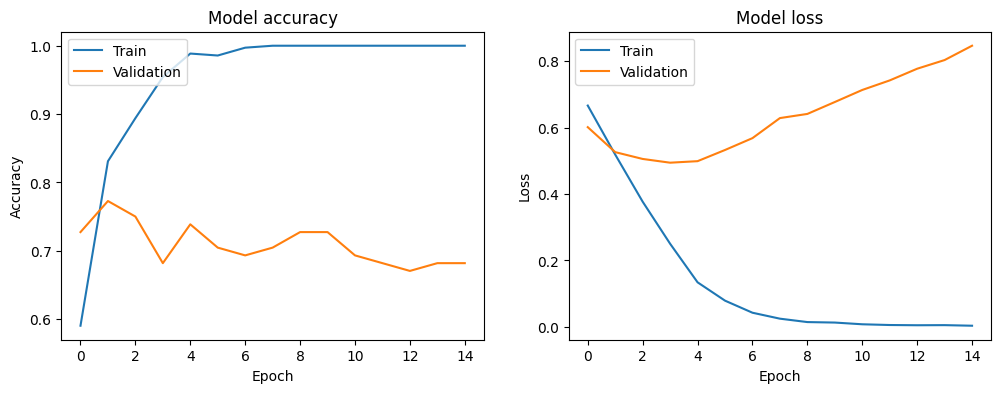

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [38]:
start_time = time.time()
y_pred_proba = model.predict(test_data)
end_time = time.time()

y_pred = (y_pred_proba>0.5).astype(int)

prediction_time = end_time - start_time

print("-----Neural Networks Metrics---")

print("Prediction time (seconds):", prediction_time)
print("Average time for each prediction (seconds): ",prediction_time/len(y_test))


accuracy = accuracy_score(test_labels_encoded,y_pred)
precision = precision_score(test_labels_encoded,y_pred)
recall = recall_score(test_labels_encoded,y_pred)
f1 = f1_score(test_labels_encoded,y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall {recall}")
print(f"F1-Score: {f1}")



4/4 [==============================] - 0s 9ms/step
-----Neural Networks Metrics---
Prediction time (seconds): 0.2663915157318115
Average time for each prediction (seconds):  0.0024217410521073777
Accuracy: 0.7636363636363637
Precision: 0.7534246575342466
Recall 0.873015873015873
F1-Score: 0.8088235294117647


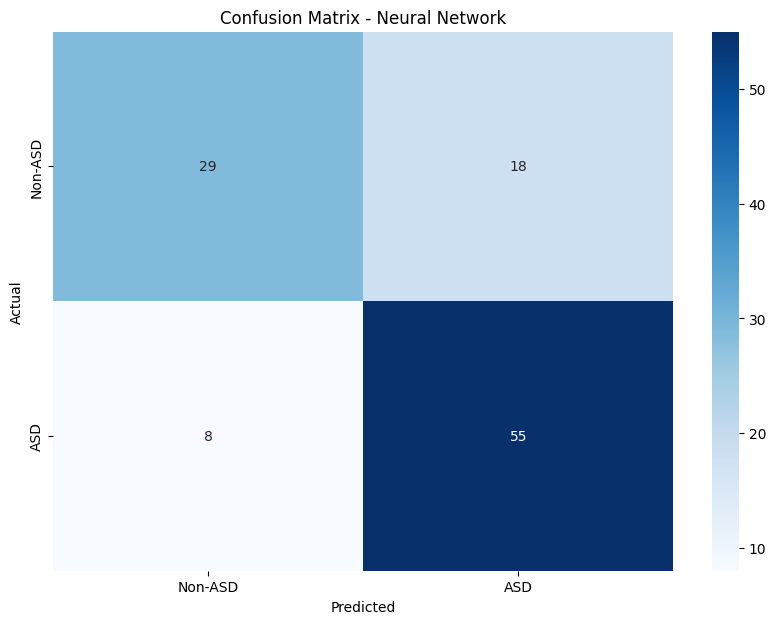

In [39]:
conf_matrix = confusion_matrix(test_labels_encoded,y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-ASD', 'ASD'], yticklabels=['Non-ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

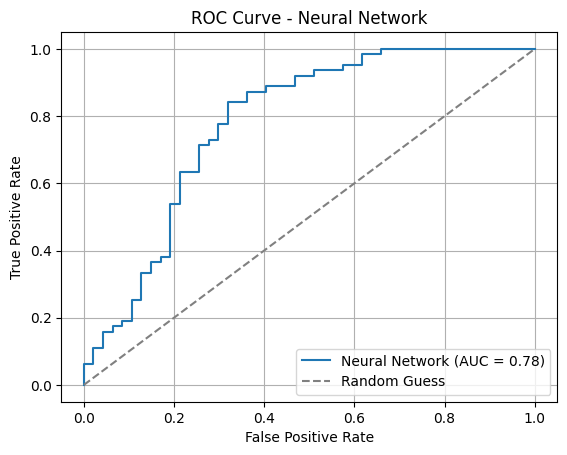

In [40]:
#model_probs = best_model.predict_proba(X_test)[:, 1]
model_probs = y_pred_proba
model_auc =roc_auc_score(y_test, model_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs,pos_label='Non-ASD')

plt.plot(model_fpr, model_tpr, label=f'Neural Network (AUC = {model_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(True)


## Convolutional Random Forest

In [41]:
filters = Sequential([
    Conv2D(32,(5,5),activation='relu', input_shape=(225,225,1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(5,5),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten()
])

filters.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 179776)            0         
                                                                 
Total params: 52,096
Trainable params: 52,096
Non-trai

In [42]:
train_features = filters.predict(train_data)  


14/14 [==============================] - 6s 454ms/step


In [43]:
crf = RandomForestClassifier()
crf.fit(train_features,train_labels_encoded)

RandomForestClassifier()

### Evaluating the model

In [44]:

test_features = filters.predict(test_data)    # Extract data

start_time = time.time()
y_pred = crf.predict(test_features)
end_time = time.time()


prediction_time = end_time - start_time

print("----- Convolutional filter Random Forest Metrics---")

print("Prediction time (seconds):", prediction_time)
print("Average time for each prediction (seconds): ",prediction_time/len(y_test))

accuracy = accuracy_score(test_labels_encoded,y_pred)
precision = precision_score(test_labels_encoded,y_pred)
recall = recall_score(test_labels_encoded,y_pred)
f1 = f1_score(test_labels_encoded,y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall {recall}")
print(f"F1-Score: {f1}")

4/4 [==============================] - 2s 396ms/step
----- Convolutional filter Random Forest Metrics---
Prediction time (seconds): 0.06981229782104492
Average time for each prediction (seconds):  0.0006346572529185902
Accuracy: 0.7636363636363637
Precision: 0.7681159420289855
Recall 0.8412698412698413
F1-Score: 0.8030303030303031


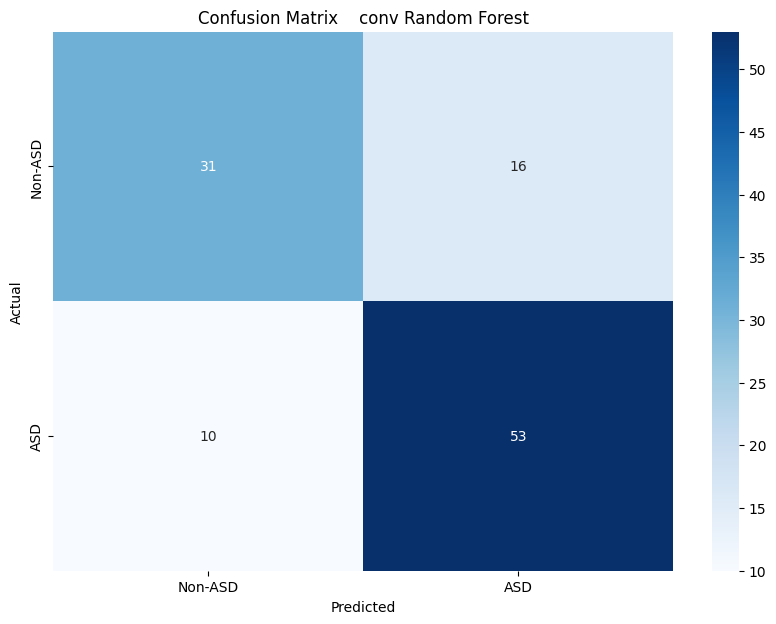

In [53]:
conf_matrix = confusion_matrix(test_labels_encoded,y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-ASD', 'ASD'], yticklabels=['Non-ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix    conv Random Forest')
plt.show()

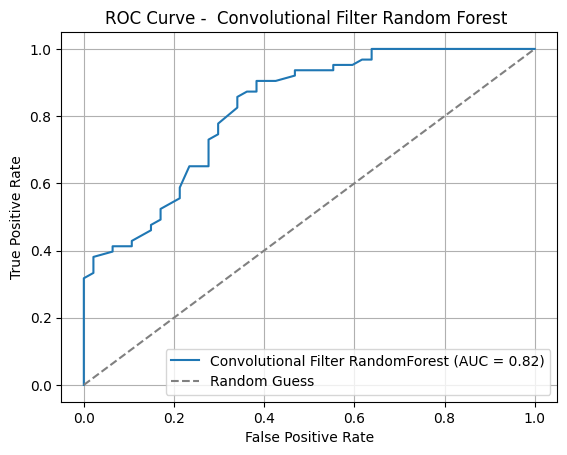

In [46]:
rf_probs = crf.predict_proba(test_features)[:, 1]
rf_auc =roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs,pos_label='Non-ASD')

plt.plot(rf_fpr, rf_tpr, label=f'Convolutional Filter RandomForest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -  Convolutional Filter Random Forest ')
plt.legend()
plt.grid(True)


## CNN

In [47]:
Cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225,1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
cnn_history =Cnn_model.fit(train_data,train_labels_encoded,epochs=15,batch_size=32,validation_split=0.2,verbose=1)

Epoch 1/15
11/11 [==============================] - 24s 2s/step - loss: 0.6858 - accuracy: 0.5931 - val_loss: 0.6550 - val_accuracy: 0.6136
Epoch 2/15
11/11 [==============================] - 22s 2s/step - loss: 0.6109 - accuracy: 0.6963 - val_loss: 0.5102 - val_accuracy: 0.7614
Epoch 3/15
11/11 [==============================] - 21s 2s/step - loss: 0.6088 - accuracy: 0.6991 - val_loss: 0.5133 - val_accuracy: 0.7500
Epoch 4/15
11/11 [==============================] - 22s 2s/step - loss: 0.5405 - accuracy: 0.7364 - val_loss: 0.5023 - val_accuracy: 0.7614
Epoch 5/15
11/11 [==============================] - 21s 2s/step - loss: 0.4906 - accuracy: 0.7507 - val_loss: 0.5196 - val_accuracy: 0.7386
Epoch 6/15
11/11 [==============================] - 21s 2s/step - loss: 0.5136 - accuracy: 0.7450 - val_loss: 0.5393 - val_accuracy: 0.7500
Epoch 7/15
11/11 [==============================] - 21s 2s/step - loss: 0.5045 - accuracy: 0.7679 - val_loss: 0.4783 - val_accuracy: 0.7159
Epoch 8/15
11/11 [==

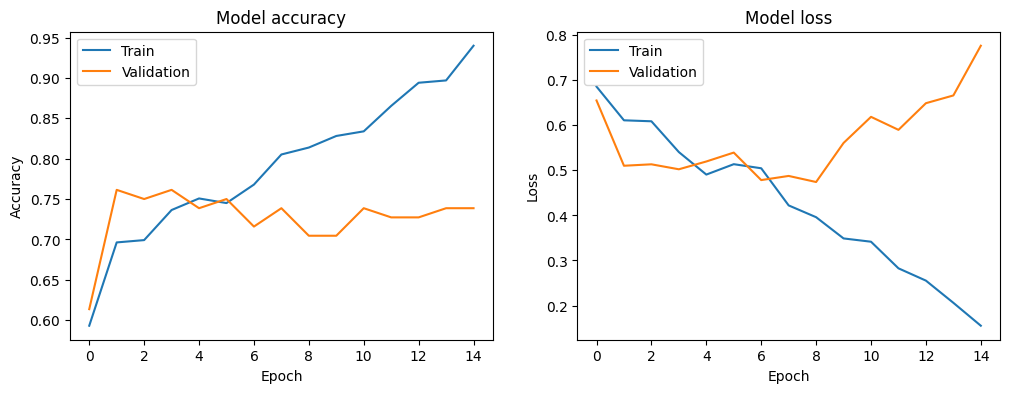

In [49]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [50]:
start_time = time.time()
cnn_y_pred_proba = Cnn_model.predict(test_data)
end_time = time.time()

cnn_y_pred = (cnn_y_pred_proba>0.5).astype(int)
prediction_time = end_time - start_time

print("-----Convolutional Neural Networks Metrics---")

print("Prediction time (seconds):", prediction_time)
print("Average time for each prediction (seconds): ",prediction_time/len(y_test))


accuracy = accuracy_score(test_labels_encoded,y_pred)
precision = precision_score(test_labels_encoded,y_pred)
recall = recall_score(test_labels_encoded,y_pred)
f1 = f1_score(test_labels_encoded,y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall {recall}")
print(f"F1-Score: {f1}")



4/4 [==============================] - 1s 323ms/step
-----Convolutional Neural Networks Metrics---
Prediction time (seconds): 1.4961743354797363
Average time for each prediction (seconds):  0.013601584867997603
Accuracy: 0.7636363636363637
Precision: 0.7681159420289855
Recall 0.8412698412698413
F1-Score: 0.8030303030303031


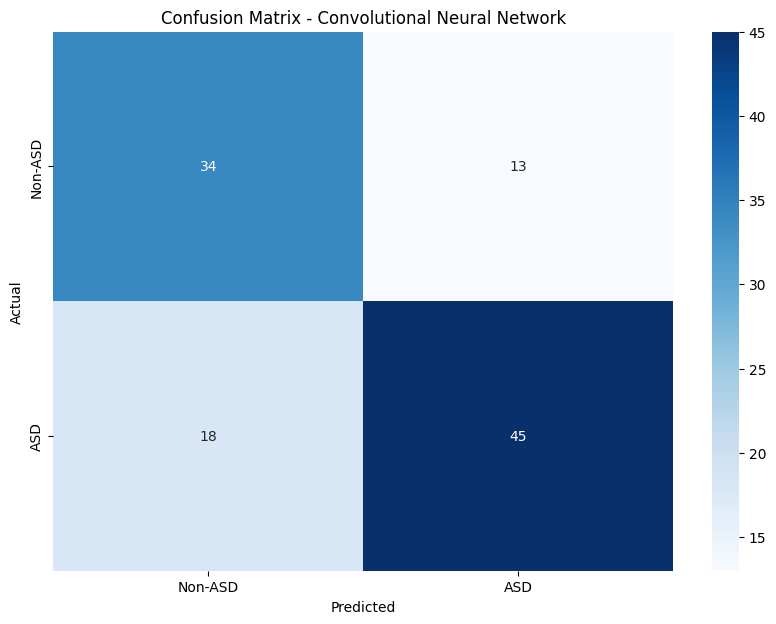

In [51]:
conf_matrix = confusion_matrix(test_labels_encoded,cnn_y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-ASD', 'ASD'], yticklabels=['Non-ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Convolutional Neural Network')
plt.show()

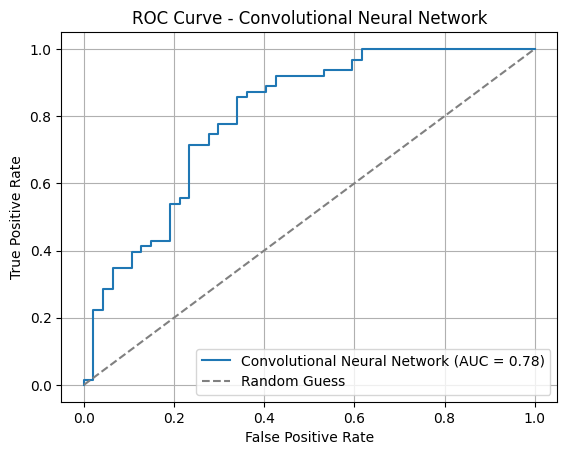

In [52]:
#cnn_probs = best_cnn.predict_proba(X_test)[:, 1]
cnn_probs=cnn_y_pred_proba
cnn_auc =roc_auc_score(y_test, model_probs)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_probs,pos_label='Non-ASD')

plt.plot(cnn_fpr, cnn_tpr, label=f'Convolutional Neural Network (AUC = {cnn_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Convolutional Neural Network')
plt.legend()
plt.grid(True)
